# Ejercicio 1

## B

In [ ]:
import Pkg; Pkg.add("GLPK")
using JuMP
using GLPK

# Conjuntos
I = 1:3
J = 1:3

# Oferta (miles de galones)
supply = Dict(1=>6000, 2=>5000, 3=>8000)
# Demanda (miles de galones)
demand = Dict(1=>4000, 2=>8000, 3=>7000)

# Distancias (km), Inf = sin conexión
distance = Dict(
    (1,1)=>120, (1,2)=>180, (1,3)=>Inf,
    (2,1)=>300, (2,2)=>100, (2,3)=>80,
    (3,1)=>200, (3,2)=>250, (3,3)=>120
)

A = [(i,j) for i in I, j in J if isfinite(distance[(i,j)])]
cost = Dict( (i,j)=>0.1*distance[(i,j)] for (i,j) in A )

# Modelo
model = Model(GLPK.Optimizer)

@variable(model, x[a in A] >= 0)

# Restricciones de oferta
for i in I
    @constraint(model,
        sum(x[(i,j)] for j in J if (i,j) in A) == supply[i]
    )
end

# Restricciones de demanda
for j in J
    @constraint(model,
        sum(x[(i,j)] for i in I if (i,j) in A) == demand[j]
    )
end

@objective(model, Min,
    sum(cost[a] * x[a] for a in A)
)

optimize!(model)

println("Costo óptimo: \$", objective_value(model))
for (i,j) in A
    q = value(x[(i,j)])
    if q > 1e-6
        println("Enviar ", q, " miles gal. de ref. ", i, " → área ", j)
    end
end


    Updating registry at `C:\Users\irvin\.julia\registries\General.toml`
   Resolving package versions...
   Installed GLPK_jll ─ v5.0.1+1
   Installed GLPK ───── v1.2.1
    Updating `C:\Users\irvin\.julia\environments\v1.11\Project.toml`
  [60bf3e95] + GLPK v1.2.1
    Updating `C:\Users\irvin\.julia\environments\v1.11\Manifest.toml`
  [60bf3e95] + GLPK v1.2.1
  [e8aa6df9] + GLPK_jll v5.0.1+1
  [781609d7] + GMP_jll v6.3.0+0
Precompiling project...
   9564.3 ms  ✓ GLPK_jll
  14982.6 ms  ✓ GLPK
  2 dependencies successfully precompiled in 123 seconds. 308 already precompiled.


Costo óptimo: $243000.0
Enviar 4000.0 miles gal. de ref. 1 → área 1
Enviar 2000.0 miles gal. de ref. 1 → área 2
Enviar 5000.0 miles gal. de ref. 2 → área 2
Enviar 1000.0 miles gal. de ref. 3 → área 2
Enviar 7000.0 miles gal. de ref. 3 → área 3


## C

In [ ]:
# Conjuntos
I = 1:3
J = 1:3

# Oferta
supply = Dict(1=>6000, 2=>5000, 3=>8000)
# Nueva demanda
demand = Dict(1=>4000, 2=>8000, 3=>4000)

# Distancias (km)
distance = Dict(
    (1,1)=>120, (1,2)=>180, (1,3)=>Inf,
    (2,1)=>300, (2,2)=>100, (2,3)=>80,
    (3,1)=>200, (3,2)=>250, (3,3)=>120
)

# Arcos válidos
A = [(i,j) for i in I, j in J if isfinite(distance[(i,j)])]
# Costo tubería $/mil gal
cost_pipe = Dict( (i,j)=>0.1*distance[(i,j)] for (i,j) in A )
# Costo camión $/mil gal para i=1,2
truck_cost = Dict(1=>15.0, 2=>22.0)

model2 = Model(GLPK.Optimizer)

@variable(model2, x[a in A] >= 0)
@variable(model2, y[i in 1:2] >= 0)

# Oferta para 1 y 2: tubería + camión = capacidad
for i in 1:2
    @constraint(model2,
        sum(x[(i,j)] for j in J if (i,j) in A) + y[i] == supply[i]
    )
end
# Refinería 3: solo tubería ≤ capacidad
@constraint(model2,
    sum(x[(3,j)] for j in J if (3,j) in A) <= supply[3]
)

# Demanda
for j in J
    @constraint(model2,
        sum(x[(i,j)] for i in I if (i,j) in A) == demand[j]
    )
end

@objective(model2, Min,
    sum(cost_pipe[a] * x[a] for a in A) +
    sum(truck_cost[i] * y[i] for i in 1:2)
)

optimize!(model2)

println("Costo óptimo (con camión): \$", objective_value(model2))
for (i,j) in A
    q = value(x[(i,j)])
    if q > 1e-6
        println("Tubería: enviar ", q, " miles gal. de ref. ", i, " → área ", j)
    end
end
for i in 1:2
    t = value(y[i])
    if t > 1e-6
        println("Camión (excedente ref. $i): ", t, " miles gal.")
    end
end

Costo óptimo (con camión): $207000.0
Tubería: enviar 4000.0 miles gal. de ref. 1 → área 1
Tubería: enviar 2000.0 miles gal. de ref. 1 → área 2
Tubería: enviar 5000.0 miles gal. de ref. 2 → área 2
Tubería: enviar 1000.0 miles gal. de ref. 3 → área 2
Tubería: enviar 4000.0 miles gal. de ref. 3 → área 3


# Ejercicio 2

In [ ]:
# trabajadores (6 filas)
I = 1:6

# tareas (7 columnas)
J = 1:7

# Matriz de costos: cada fila i y columna j es el costo de asignar i→j
cost = [
    3   8   2  10   3   3   9;
    2   2   7   6   5   2   7;
    5   6   4   5   6   6   6;
    4   2   7   5   9   4   7;
   10   3   8   4   2   3   5;
    3   5   4   2   3   7   8
]

model = Model(GLPK.Optimizer)

# Variable binaria x[i,j] = 1 si el trabajador i hace la tarea j, 0 en caso contrario
@variable(model, x[i in I, j in J], Bin)

# Restricción: cada trabajador i debe hacer exactamente una tarea
@constraint(model, [i in I], sum(x[i,j] for j in J) == 1)

# Restricción: cada tarea j es hecha por como máximo un trabajador
@constraint(model, [j in J], sum(x[i,j] for i in I) <= 1)

# Objetivo: minimizar el costo total de las asignaciones
@objective(model, Min, sum(cost[i,j] * x[i,j] for i in I, j in J))

optimize!(model)

println("Costo total óptimo: ", objective_value(model))
for i in I, j in J
    if value(x[i,j]) > 0.5
        println("Trabajador ", i,
                " → Tarea ", j,
                "  (costo = ", cost[i,j], ")")
    end
end

Costo total óptimo: 15.0
Trabajador 1 → Tarea 1  (costo = 3)
Trabajador 2 → Tarea 6  (costo = 2)
Trabajador 3 → Tarea 3  (costo = 4)
Trabajador 4 → Tarea 2  (costo = 2)
Trabajador 5 → Tarea 5  (costo = 2)
Trabajador 6 → Tarea 4  (costo = 2)


# Ejercicio 3

In [ ]:
# trabajadores (1 a 4)
workers = 1:4
# puestos (1 a 4)
jobs     = 1:4

# Definir la matriz de costos; 
cost_matrix = [
    50   50  Inf   20;   # Trabajador 1 no puede hacer el puesto 3
    70   40   20   30;
    90   30   50  Inf;   # Trabajador 3 no puede hacer el puesto 4
    70   20   60   70
]

# Construir la lista de pares (i,j) con costo finito
allowed = [(i,j) for i in workers, j in jobs if isfinite(cost_matrix[i,j])]

model = Model(GLPK.Optimizer)

# Definir variable binaria x[i,j] = 1 si i se asigna a j, 0 en otro caso
@variable(model, x[a in allowed], Bin)

# Cada trabajador i debe hacer exactamente un puesto
for i in workers
    @constraint(model, sum(x[(i,j)] for j in jobs if (i,j) in allowed) == 1)
end

# Cada puesto j debe ser cubierto por exactamente un trabajador
for j in jobs
    @constraint(model, sum(x[(i,j)] for i in workers if (i,j) in allowed) == 1)
end

# Definir el objetivo: minimizar la suma de costos de las asignaciones
@objective(model, Min, sum(cost_matrix[i,j] * x[(i,j)] for (i,j) in allowed))

optimize!(model)
println("Costo óptimo total: ", objective_value(model))
for (i,j) in allowed
    if value(x[(i,j)]) > 0.5
        println("Trabajador ", i, " → Puesto ", j,
                "   (costo = ", cost_matrix[i,j], ")")
    end
end

Costo óptimo total: 140.0
Trabajador 4 → Puesto 1   (costo = 70.0)
Trabajador 3 → Puesto 2   (costo = 30.0)
Trabajador 2 → Puesto 3   (costo = 20.0)
Trabajador 1 → Puesto 4   (costo = 20.0)


# Ejercicio 4

Implementar en Python los tres algoritmos vistos en clase para hallar los ceros de una función `f : [a, b] → ℝ`:

- método de bisección  
- método de la secante  
- método de Newton‑Raphson  

Como parámetros, sus algoritmos deben recibir la función `f`, la derivada `df` (en el caso de Newton), el intervalo `[a, b]` o el punto inicial de búsqueda `x0 ∈ ℝ`. Así como los criterios de paro `iter` y `tol > 0`.  

Para la salida, sus funciones deben devolver la lista de aproximaciones realizadas y el valor de punto `x*` donde se encontró el cero.


In [1]:
def metodo_biseccion(f, a, b, tol=1e-6, iter_max=100):
    """
    Encuentra un cero de la función f en el intervalo [a, b] usando el método de bisección.
    
    Parámetros:
    - f: función a la que se le busca el cero
    - a, b: extremos del intervalo [a, b]
    - tol: tolerancia para el criterio de parada
    - iter_max: número máximo de iteraciones permitidas
    
    Retorna:
    - aproximaciones: lista de aproximaciones generadas
    - x: aproximación final del cero
    """
    if f(a) * f(b) >= 0:
        raise ValueError("La función debe cambiar de signo en el intervalo [a, b]")
    
    aproximaciones = []
    for _ in range(iter_max):
        c = (a + b) / 2
        aproximaciones.append(c)
        
        if abs(f(c)) < tol:
            break
            
        if f(a) * f(c) < 0:
            b = c
        else:
            a = c
    
    return aproximaciones, aproximaciones[-1]

In [2]:
def metodo_secante(f, x0, x1, tol=1e-6, iter_max=100):
    """
    Encuentra un cero de la función f usando el método de la secante.
    
    Parámetros:
    - f: función a la que se le busca el cero
    - x0, x1: aproximaciones iniciales
    - tol: tolerancia para el criterio de parada
    - iter_max: número máximo de iteraciones permitidas
    
    Retorna:
    - aproximaciones: lista de aproximaciones generadas
    - x: aproximación final del cero
    """
    aproximaciones = [x0, x1]
    
    for _ in range(iter_max):
        fx0 = f(x0)
        fx1 = f(x1)
        
        if abs(fx1) < tol:
            break
            
        x_next = x1 - fx1 * (x1 - x0) / (fx1 - fx0)
        aproximaciones.append(x_next)
        
        x0, x1 = x1, x_next
    
    return aproximaciones, aproximaciones[-1]

In [11]:
def metodo_newton(f, df, x0, tol=1e-6, iter_max=100):
    """
    Encuentra un cero de la función f usando el método de Newton-Raphson.
    
    Parámetros:
    - f: función a la que se le busca el cero
    - df: derivada de la función f
    - x0: aproximación inicial
    - tol: tolerancia para el criterio de parada
    - iter_max: número máximo de iteraciones permitidas
    
    Retorna:
    - aproximaciones: lista de aproximaciones generadas
    - x: aproximación final del cero
    """
    aproximaciones = [x0]
    
    for _ in range(iter_max):
        fx = f(x0)
        dfx = df(x0)
        
        if abs(fx) < tol:
            break
            
        x_next = x0 - fx / dfx
        aproximaciones.append(x_next)
        
        x0 = x_next
    
    return aproximaciones, aproximaciones[-1]

# Ejercicio 5

Hallar todos los ceros de la funciósn
g(x) = x**2 + 1/(x − 7)

con al menos 7 decimales de precisi´on.
Compare las soluciones obtenidas con cada uno de los algoritmos anterioes en términos del número de iteraciones.

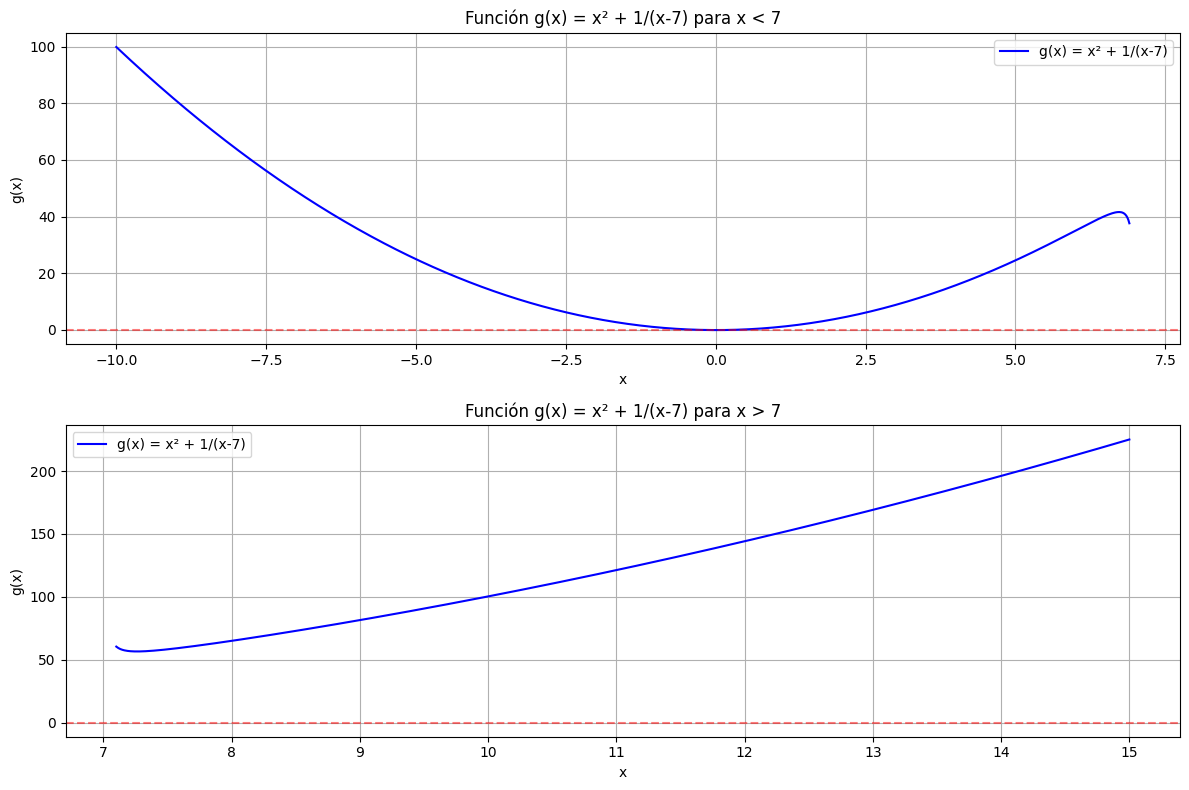

Evaluación de g(x) en algunos puntos:
g(-5) = 24.9167
g(-2) = 3.8889
g(0) = -0.1429
g(2) = 3.8000
g(5) = 24.5000
g(6) = 35.0000
g(8) = 65.0000
g(10) = 100.3333
g(12) = 144.2000


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Definir la función g(x) = x^2 + 1/(x - 7)
def g(x):
    return x**2 + 1/(x - 7)

# Derivada de g(x): g'(x) = 2x - 1/(x - 7)^2
def dg(x):
    return 2*x - 1/(x - 7)**2

# Primero, analicemos la función para identificar los intervalos donde pueden estar los ceros
# La función tiene una asíntota vertical en x = 7, así que necesitamos buscar en (-∞, 7) y (7, ∞)

# Graficar la función para visualizar los ceros
x1 = np.linspace(-10, 6.9, 1000)
x2 = np.linspace(7.1, 15, 1000)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(x1, g(x1), 'b-', label='g(x) = x² + 1/(x-7)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True)
plt.title('Función g(x) = x² + 1/(x-7) para x < 7')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x2, g(x2), 'b-', label='g(x) = x² + 1/(x-7)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True)
plt.title('Función g(x) = x² + 1/(x-7) para x > 7')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar la función en algunos puntos para identificar cambios de signo
print("Evaluación de g(x) en algunos puntos:")
puntos_test = [-5, -2, 0, 2, 5, 6, 8, 10, 12]
for x in puntos_test:
    if x != 7:  # Evitar la asíntota
        print(f"g({x}) = {g(x):.4f}")

In [5]:
# Aplicar los tres métodos para encontrar el cero de g(x) con 7 decimales de precisión
print("="*60)
print("BÚSQUEDA DEL CERO DE g(x) = x² + 1/(x-7)")
print("="*60)

# Parámetros para 7 decimales de precisión
tol = 1e-7
iter_max = 100

# 1. MÉTODO DE BISECCIÓN
print("\n1. MÉTODO DE BISECCIÓN")
print("-" * 25)
# Usamos el intervalo [-2, 0] donde la función cambia de signo
a, b = -2, 0
try:
    aprox_biseccion, raiz_biseccion = metodo_biseccion(g, a, b, tol, iter_max)
    print(f"Intervalo inicial: [{a}, {b}]")
    print(f"Número de iteraciones: {len(aprox_biseccion)}")
    print(f"Raíz encontrada: {raiz_biseccion:.7f}")
    print(f"Verificación g({raiz_biseccion:.7f}) = {g(raiz_biseccion):.2e}")
except Exception as e:
    print(f"Error en bisección: {e}")

# 2. MÉTODO DE LA SECANTE
print("\n2. MÉTODO DE LA SECANTE")
print("-" * 25)
# Usamos dos puntos iniciales cercanos al cero
x0, x1 = -2, 0
try:
    aprox_secante, raiz_secante = metodo_secante(g, x0, x1, tol, iter_max)
    print(f"Puntos iniciales: x0 = {x0}, x1 = {x1}")
    print(f"Número de iteraciones: {len(aprox_secante)}")
    print(f"Raíz encontrada: {raiz_secante:.7f}")
    print(f"Verificación g({raiz_secante:.7f}) = {g(raiz_secante):.2e}")
except Exception as e:
    print(f"Error en secante: {e}")

# 3. MÉTODO DE NEWTON-RAPHSON
print("\n3. MÉTODO DE NEWTON-RAPHSON")
print("-" * 30)
# Usamos un punto inicial cercano al cero
x0 = -1
try:
    aprox_newton, raiz_newton = metodo_newton(g, dg, x0, tol, iter_max)
    print(f"Punto inicial: x0 = {x0}")
    print(f"Número de iteraciones: {len(aprox_newton)}")
    print(f"Raíz encontrada: {raiz_newton:.7f}")
    print(f"Verificación g({raiz_newton:.7f}) = {g(raiz_newton):.2e}")
except Exception as e:
    print(f"Error en Newton: {e}")

# COMPARACIÓN DE RESULTADOS
print("\n" + "="*60)
print("COMPARACIÓN DE MÉTODOS")
print("="*60)
print(f"{'Método':<20} {'Iteraciones':<12} {'Raíz (7 decimales)':<20}")
print("-" * 52)
print(f"{'Bisección':<20} {len(aprox_biseccion):<12} {raiz_biseccion:.7f}")
print(f"{'Secante':<20} {len(aprox_secante):<12} {raiz_secante:.7f}")
print(f"{'Newton-Raphson':<20} {len(aprox_newton):<12} {raiz_newton:.7f}")

# Verificar que todos convergen al mismo valor
diferencia_max = max(abs(raiz_biseccion - raiz_secante), 
                    abs(raiz_biseccion - raiz_newton), 
                    abs(raiz_secante - raiz_newton))
print(f"\nDiferencia máxima entre métodos: {diferencia_max:.2e}")

if diferencia_max < 1e-6:
    print("✓ Todos los métodos convergen al mismo resultado")
else:
    print("⚠ Los métodos tienen diferencias significativas")

BÚSQUEDA DEL CERO DE g(x) = x² + 1/(x-7)

1. MÉTODO DE BISECCIÓN
-------------------------
Intervalo inicial: [-2, 0]
Número de iteraciones: 20
Raíz encontrada: -0.3683949
Verificación g(-0.3683949) = -1.55e-09

2. MÉTODO DE LA SECANTE
-------------------------
Puntos iniciales: x0 = -2, x1 = 0
Número de iteraciones: 11
Raíz encontrada: -0.3683948
Verificación g(-0.3683948) = -6.96e-08

3. MÉTODO DE NEWTON-RAPHSON
------------------------------
Punto inicial: x0 = -1
Número de iteraciones: 6
Raíz encontrada: -0.3683949
Verificación g(-0.3683949) = 6.45e-12

COMPARACIÓN DE MÉTODOS
Método               Iteraciones  Raíz (7 decimales)  
----------------------------------------------------
Bisección            20           -0.3683949
Secante              11           -0.3683948
Newton-Raphson       6            -0.3683949

Diferencia máxima entre métodos: 9.21e-08
✓ Todos los métodos convergen al mismo resultado


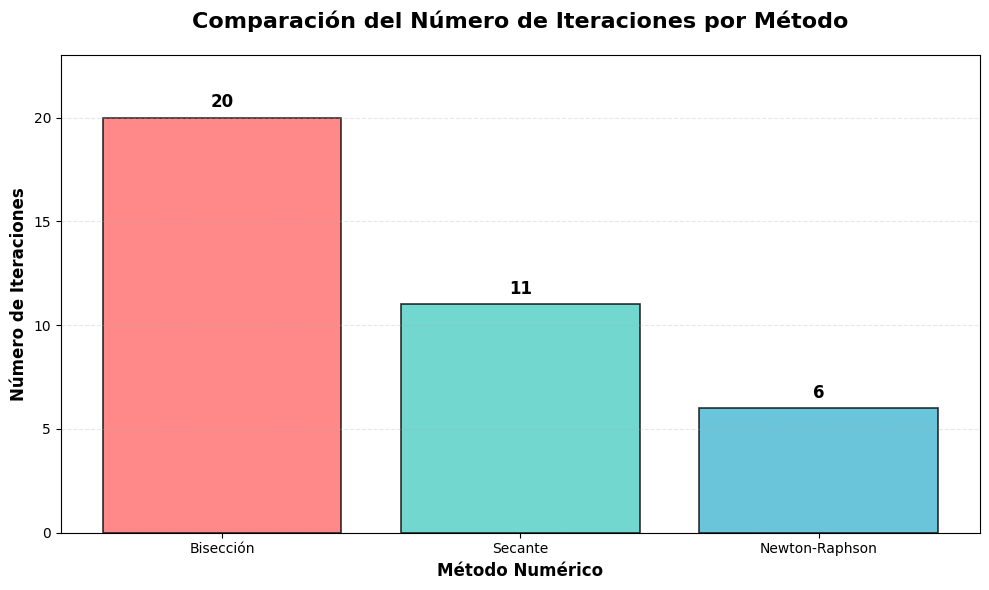


ESTADÍSTICAS DE CONVERGENCIA
Bisección      :  20 iteraciones
Secante        :  11 iteraciones
Newton-Raphson :   6 iteraciones

Método más eficiente: Newton-Raphson (6 iteraciones)
Diferencia máxima: 14 iteraciones
Factor de mejora: 3.3x (el mejor es 3.3 veces más rápido que el peor)


In [6]:
# Gráfico de barras comparando el número de iteraciones
plt.figure(figsize=(10, 6))

# Datos para el gráfico
metodos = ['Bisección', 'Secante', 'Newton-Raphson']
iteraciones = [len(aprox_biseccion), len(aprox_secante), len(aprox_newton)]
colores = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Rojo, verde azulado, azul

# Crear el gráfico de barras
barras = plt.bar(metodos, iteraciones, color=colores, alpha=0.8, edgecolor='black', linewidth=1.2)

plt.title('Comparación del Número de Iteraciones por Método', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Número de Iteraciones', fontsize=12, fontweight='bold')
plt.xlabel('Método Numérico', fontsize=12, fontweight='bold')

for i, (barra, valor) in enumerate(zip(barras, iteraciones)):
    plt.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.3, 
             str(valor), ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.grid(axis='y', alpha=0.3, linestyle='--')

# Ajustar el rango del eje Y para mejor visualización
plt.ylim(0, max(iteraciones) * 1.15)

# Mejorar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Mostrar estadísticas adicionales
print("\n" + "="*50)
print("ESTADÍSTICAS DE CONVERGENCIA")
print("="*50)
for metodo, iter_count in zip(metodos, iteraciones):
    print(f"{metodo:<15}: {iter_count:>3} iteraciones")

print(f"\nMétodo más eficiente: {metodos[iteraciones.index(min(iteraciones))]} ({min(iteraciones)} iteraciones)")
print(f"Diferencia máxima: {max(iteraciones) - min(iteraciones)} iteraciones")

# Calcular factor de mejora
factor_mejora = max(iteraciones) / min(iteraciones)
print(f"Factor de mejora: {factor_mejora:.1f}x (el mejor es {factor_mejora:.1f} veces más rápido que el peor)")

# Ejercicio 6

Hallar todos los ceros del polinomio

$$f(x) = 2x^5 + 3x^4 - 3x^3 - 10x^2 - 4x + 4$$

mediante los algoritmos numéricos.


ANÁLISIS DEL POLINOMIO f(x) = 2x^5 + 3x^4 - 3x^3 - 10x^2 - 4x + 4

Evaluación de f(x) en puntos clave:
f(-5.0) = -4226.00
f(-4.5) = -2367.50
f(-4.0) = -1228.00
f(-3.5) =  -576.12
f(-3.0) =  -236.00
f(-2.5) =   -79.75
f(-2.0) =   -20.00
f(-1.5) =    -2.38
f(-1.0) =     2.00
f(-0.5) =     4.00
f( 0.0) =     4.00
f( 0.5) =    -0.62
f( 1.0) =    -8.00
f( 1.5) =    -4.25
f( 2.0) =    44.00
f( 2.5) =   197.12
f( 3.0) =   550.00

Intervalos con cambios de signo encontrados: 3
  Intervalo 1: [-1.5, -1.0]
  Intervalo 2: [0.0, 0.5]
  Intervalo 3: [1.5, 2.0]

BÚSQUEDA DE CEROS CON LOS TRES MÉTODOS

--- CERO 1 en el intervalo [-1.5, -1.0] ---
Bisección:     -1.3037028 (24 iteraciones)
Secante:       -1.3037028 (8 iteraciones)
Newton-Raphson: -1.3037028 (4 iteraciones)
Cero confirmado: -1.3037028

--- CERO 2 en el intervalo [0.0, 0.5] ---
Bisección:     0.4546076 (25 iteraciones)
Secante:       0.4546076 (6 iteraciones)
Newton-Raphson: 0.4546076 (5 iteraciones)
Cero confirmado: 0.4546076

--- CERO 

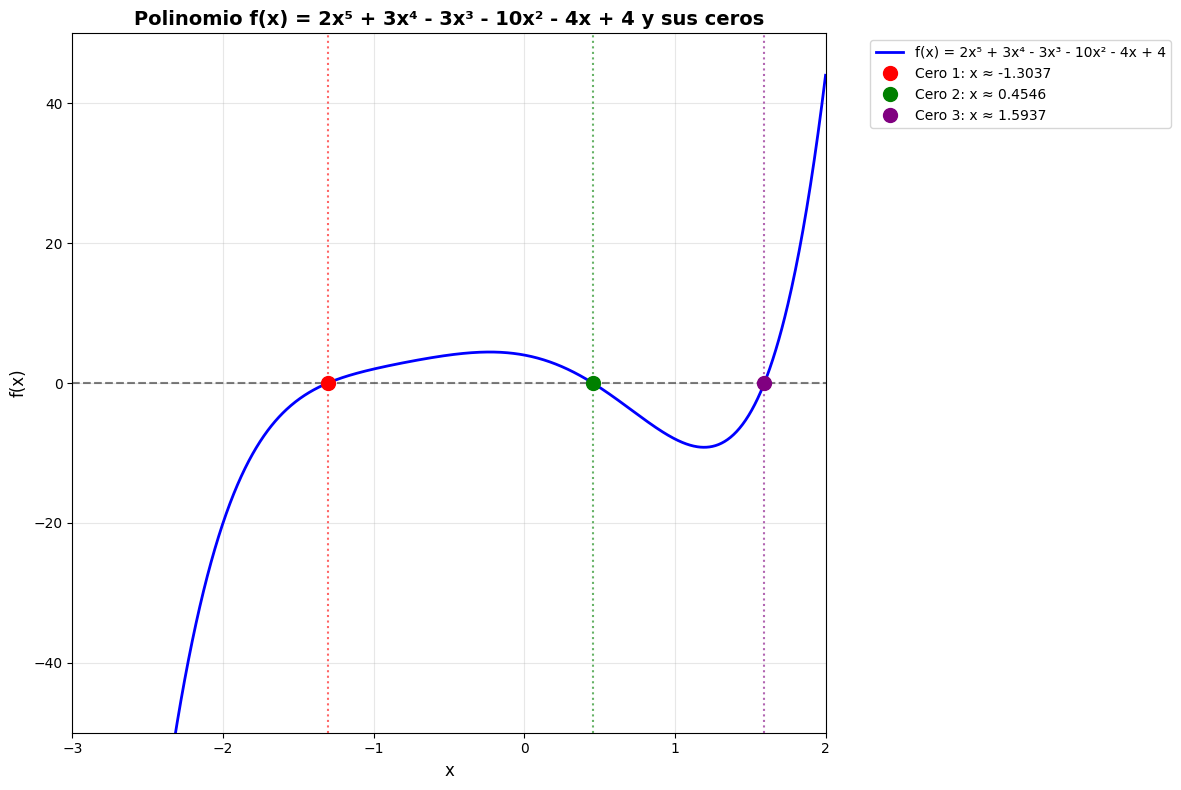

<Figure size 1200x600 with 0 Axes>

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Definir el polinomio f(x) = 2x^5 + 3x^4 - 3x^3 - 10x^2 - 4x + 4
def f(x):
    return 2*x**5 + 3*x**4 - 3*x**3 - 10*x**2 - 4*x + 4

# Derivada del polinomio f'(x) = 10x^4 + 12x^3 - 9x^2 - 20x - 4
def df(x):
    return 10*x**4 + 12*x**3 - 9*x**2 - 20*x - 4

# Analizar la función para encontrar intervalos donde cambia de signo
print("="*60)
print("ANÁLISIS DEL POLINOMIO f(x) = 2x^5 + 3x^4 - 3x^3 - 10x^2 - 4x + 4")
print("="*60)

# Evaluar en varios puntos para identificar cambios de signo
x_test = np.linspace(-5, 3, 17)
print("\nEvaluación de f(x) en puntos clave:")
for x in x_test:
    print(f"f({x:4.1f}) = {f(x):8.2f}")

# Identificar intervalos donde la función cambia de signo
intervalos = []
for i in range(len(x_test)-1):
    if f(x_test[i]) * f(x_test[i+1]) < 0:
        intervalos.append((x_test[i], x_test[i+1]))

print(f"\nIntervalos con cambios de signo encontrados: {len(intervalos)}")
for i, (a, b) in enumerate(intervalos, 1):
    print(f"  Intervalo {i}: [{a:.1f}, {b:.1f}]")

# Encontrar todos los ceros usando los tres métodos
print("\n" + "="*60)
print("BÚSQUEDA DE CEROS CON LOS TRES MÉTODOS")
print("="*60)

ceros_encontrados = []
tol = 1e-7
iter_max = 100

for i, (a, b) in enumerate(intervalos, 1):
    print(f"\n--- CERO {i} en el intervalo [{a:.1f}, {b:.1f}] ---")
    
    # Método de Bisección
    try:
        aprox_bis, raiz_bis = metodo_biseccion(f, a, b, tol, iter_max)
        iter_bis = len(aprox_bis)
        print(f"Bisección:     {raiz_bis:.7f} ({iter_bis} iteraciones)")
    except Exception as e:
        print(f"Bisección: Error - {e}")
        raiz_bis, iter_bis = None, 0
    
    # Método de la Secante
    try:
        aprox_sec, raiz_sec = metodo_secante(f, a, b, tol, iter_max)
        iter_sec = len(aprox_sec)
        print(f"Secante:       {raiz_sec:.7f} ({iter_sec} iteraciones)")
    except Exception as e:
        print(f"Secante: Error - {e}")
        raiz_sec, iter_sec = None, 0
    
    # Método de Newton-Raphson (usar punto medio como inicial)
    x0 = (a + b) / 2
    try:
        aprox_new, raiz_new = metodo_newton(f, df, x0, tol, iter_max)
        iter_new = len(aprox_new)
        print(f"Newton-Raphson: {raiz_new:.7f} ({iter_new} iteraciones)")
    except Exception as e:
        print(f"Newton-Raphson: Error - {e}")
        raiz_new, iter_new = None, 0
    
    raices = [r for r in [raiz_bis, raiz_sec, raiz_new] if r is not None]
    if raices:
        cero_promedio = np.mean(raices)
        ceros_encontrados.append(cero_promedio)
        print(f"Cero confirmado: {cero_promedio:.7f}")

print(f"\n" + "="*60)
print("RESUMEN DE RESULTADOS")
print("="*60)
print(f"Número total de ceros encontrados: {len(ceros_encontrados)}")
for i, cero in enumerate(ceros_encontrados, 1):
    print(f"Cero {i}: x = {cero:.7f}, f(x) = {f(cero):.2e}")

# Graficar la función y marcar los ceros
plt.figure(figsize=(12, 8))
x_plot = np.linspace(-3, 2, 1000)
y_plot = f(x_plot)

plt.plot(x_plot, y_plot, 'b-', linewidth=2, label='f(x) = 2x⁵ + 3x⁴ - 3x³ - 10x² - 4x + 4')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Marcar los ceros encontrados
colores_ceros = ['red', 'green', 'purple', 'orange', 'brown']
for i, cero in enumerate(ceros_encontrados):
    color = colores_ceros[i % len(colores_ceros)]
    plt.plot(cero, 0, 'o', color=color, markersize=10, 
             label=f'Cero {i+1}: x ≈ {cero:.4f}')
    plt.axvline(x=cero, color=color, linestyle=':', alpha=0.6)

plt.title('Polinomio f(x) = 2x⁵ + 3x⁴ - 3x³ - 10x² - 4x + 4 y sus ceros', 
          fontsize=14, fontweight='bold')
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(-3, 2)
plt.ylim(-50, 50)
plt.tight_layout()
plt.show()

# Zoom en la región donde están los ceros
plt.figure(figsize=(12, 6))
x_zoom = np.linspace(-2.5, 1.5, 1000)
y_zoom = f(x_zoom)


# Ejercicio 7

Considere la función $$f(x) = x^3 − 2x + 2$$ Vamos a utilizar el método de Newton-Raphson con el punto inicial x0 = 0 para
hallar un cero de este polinomio.

7: MÉTODO DE NEWTON-RAPHSON
Función: f(x) = x³ - 2x + 2
Derivada: f'(x) = 3x² - 2
Punto inicial: x₀ = 0

Primero, intentemos con x₀ = 0 (como pide el ejercicio):
Resultado con x₀ = 0:
Número de iteraciones realizadas: 21
Último valor: x = 0.0000000
Verificación f(0.0000000) = 2.00e+00

Primeras iteraciones desde x₀ = 0:
Iteración  x               f(x)            f'(x)          
------------------------------------------------------------
0          0.00000000      2.000000e+00    -2.000000      
1          1.00000000      1.000000e+00    1.000000       
2          0.00000000      2.000000e+00    -2.000000      
3          1.00000000      1.000000e+00    1.000000       
4          0.00000000      2.000000e+00    -2.000000      
5          1.00000000      1.000000e+00    1.000000       
6          0.00000000      2.000000e+00    -2.000000      
7          1.00000000      1.000000e+00    1.000000       

⚠️  PROBLEMA: El método oscila entre 0 y 1 y no converge desde x₀ = 0

BUSCANDO EL VE

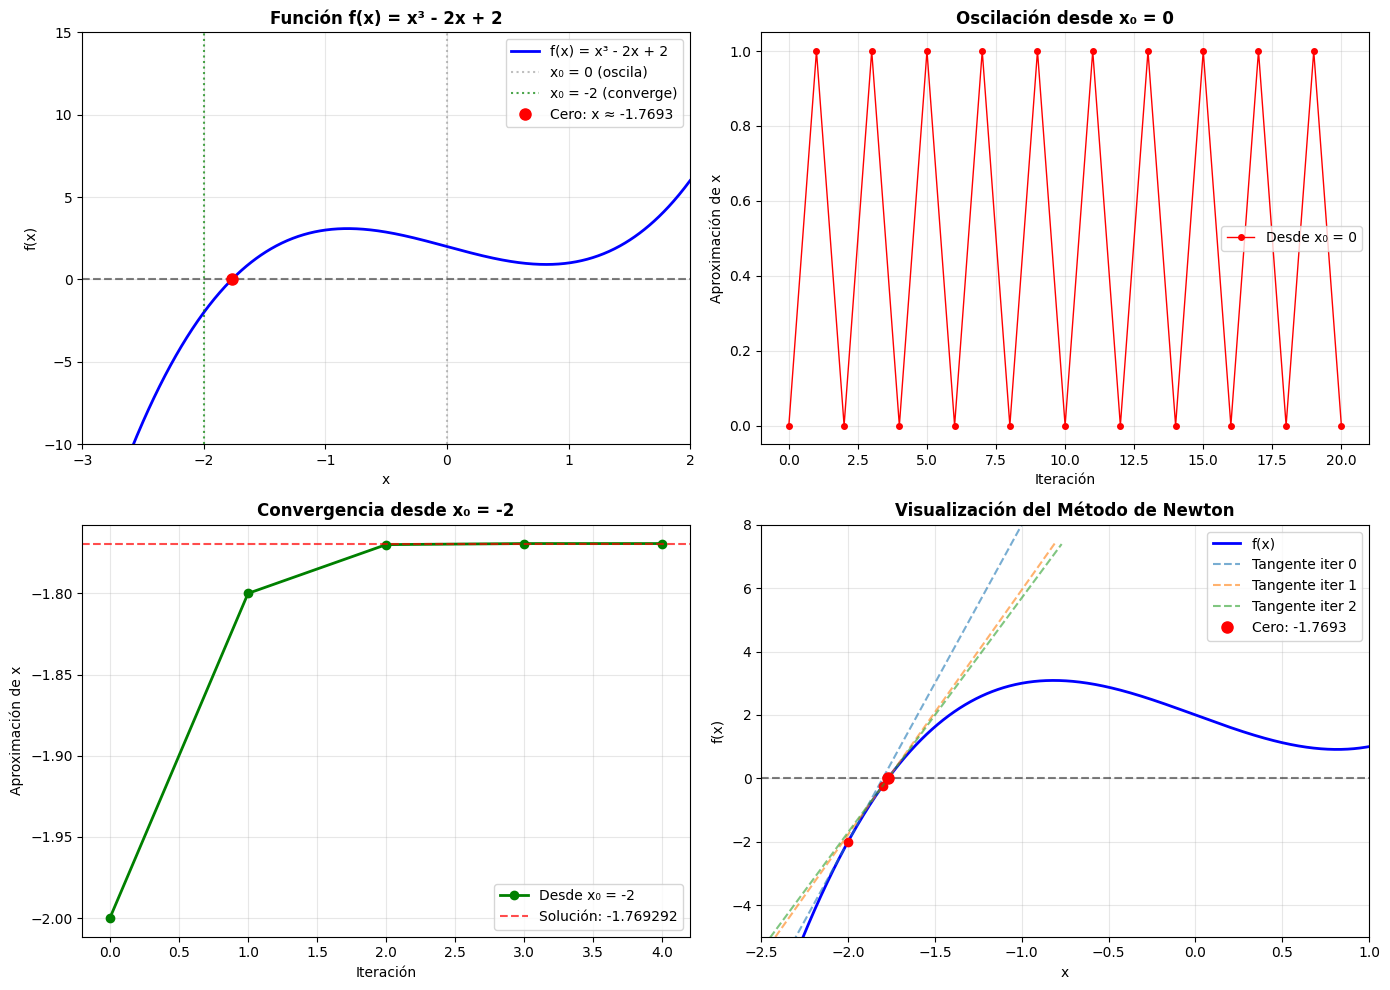


ANÁLISIS DE CONVERGENCIA
¿Por qué x₀ = 0 no converge?
-----------------------------------
Desde x₀ = 0:
  f(0) = 2
  f'(0) = -2
  x₁ = 0 - f(0)/f'(0) = 0 - 2/-2 = 1.0
  f(1) = 1
  f'(1) = 1
  x₂ = 1 - f(1)/f'(1) = 1 - 1/1 = 0.0
  → El método oscila entre 0 y 1 indefinidamente

Convergencia exitosa desde x₀ = -2:
----------------------------------------
Error relativo final: 1.74e-07
Tolerancia alcanzada: 5.05e-13
Cero real de la función: x = -1.7692924

CONCLUSIÓN DEL EJERCICIO 7
El ejercicio pide usar x₀ = 0, pero este punto inicial lleva a una
oscilación entre 0 y 1 sin convergencia al verdadero cero.
Esto demuestra la importancia de elegir un buen punto inicial
en el método de Newton-Raphson.

• Con x₀ = 0: ❌ No converge (oscila)
• Con x₀ = -2: ✅ Converge a x = -1.7692924 en 5 iteraciones


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Definir la función f(x) = x^3 - 2x + 2
def f_ej7(x):
    return x**3 - 2*x + 2

# Derivada de f(x): f'(x) = 3x^2 - 2
def df_ej7(x):
    return 3*x**2 - 2

print("="*60)
print("" \
"7: MÉTODO DE NEWTON-RAPHSON")
print("="*60)
print("Función: f(x) = x³ - 2x + 2")
print("Derivada: f'(x) = 3x² - 2")
print("Punto inicial: x₀ = 0")

# Aplicar el método de Newton-Raphson
x0 = 0
tol = 1e-7
iter_max = 20  # Reducir para mostrar el comportamiento

print(f"\nPrimero, intentemos con x₀ = 0 (como pide el ejercicio):")
try:
    aproximaciones_0, raiz_0 = metodo_newton(f_ej7, df_ej7, x0, tol, iter_max)
    
    print(f"Resultado con x₀ = 0:")
    print(f"Número de iteraciones realizadas: {len(aproximaciones_0)}")
    print(f"Último valor: x = {raiz_0:.7f}")
    print(f"Verificación f({raiz_0:.7f}) = {f_ej7(raiz_0):.2e}")
    
    # Mostrar las primeras iteraciones
    print(f"\nPrimeras iteraciones desde x₀ = 0:")
    header1 = "Iteración"; header2 = "x"; header3 = "f(x)"; header4 = "f'(x)"
    print(f"{header1:<10} {header2:<15} {header3:<15} {header4:<15}")

    print("-" * 60)
    
    for i, x in enumerate(aproximaciones_0[:8]):
        fx = f_ej7(x)
        dfx = df_ej7(x)
        print(f"{i:<10} {x:<15.8f} {fx:<15.6e} {dfx:<15.6f}")
    
    print(f"\n⚠️  PROBLEMA: El método oscila entre 0 y 1 y no converge desde x₀ = 0")
    
except Exception as e:
    print(f"Error en Newton-Raphson: {e}")

# Ahora probemos con un punto inicial diferente para encontrar el verdadero cero
print(f"\n" + "="*60)
print("BUSCANDO EL VERDADERO CERO CON UN PUNTO INICIAL DIFERENTE")
print("="*60)

x0_nuevo = -2  # Punto inicial diferente
try:
    aproximaciones, raiz = metodo_newton(f_ej7, df_ej7, x0_nuevo, tol, 100)
    
    print(f"\nResultado con x₀ = {x0_nuevo}:")
    print(f"Cero encontrado: x = {raiz:.7f}")
    print(f"Número de iteraciones: {len(aproximaciones)}")
    print(f"Verificación f({raiz:.7f}) = {f_ej7(raiz):.2e}")
    
    # Mostrar las iteraciones
    print(f"\nIteraciones desde x₀ = {x0_nuevo}:")
    header1 = "Iteración"; header2 = "x"; header3 = "f(x)"; header4 = "f'(x)"
    print(f"{header1:<10} {header2:<15} {header3:<15} {header4:<15}")

    print("-" * 60)
    
    for i, x in enumerate(aproximaciones):
        fx = f_ej7(x)
        dfx = df_ej7(x)
        print(f"{i:<10} {x:<15.8f} {fx:<15.6e} {dfx:<15.6f}")
    
except Exception as e:
    print(f"Error en Newton-Raphson: {e}")

# Graficar la función y mostrar la convergencia
plt.figure(figsize=(14, 10))

# Gráfico 1: Función y su cero
plt.subplot(2, 2, 1)
x_plot = np.linspace(-3, 2, 1000)
y_plot = f_ej7(x_plot)

plt.plot(x_plot, y_plot, 'b-', linewidth=2, label='f(x) = x³ - 2x + 2')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.5, label='x₀ = 0 (oscila)')
plt.axvline(x=-2, color='green', linestyle=':', alpha=0.7, label='x₀ = -2 (converge)')
if 'raiz' in locals():
    plt.plot(raiz, 0, 'ro', markersize=8, label=f'Cero: x ≈ {raiz:.4f}')
plt.grid(True, alpha=0.3)
plt.title('Función f(x) = x³ - 2x + 2', fontsize=12, fontweight='bold')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.xlim(-3, 2)
plt.ylim(-10, 15)

# Gráfico 2: Comportamiento desde x₀ = 0
plt.subplot(2, 2, 2)
if 'aproximaciones_0' in locals():
    iteraciones_num_0 = range(len(aproximaciones_0))
    plt.plot(iteraciones_num_0, aproximaciones_0, 'ro-', markersize=4, linewidth=1, label='Desde x₀ = 0')
plt.grid(True, alpha=0.3)
plt.title('Oscilación desde x₀ = 0', fontsize=12, fontweight='bold')
plt.xlabel('Iteración')
plt.ylabel('Aproximación de x')
plt.legend()

# Gráfico 3: Convergencia desde x₀ = -2
plt.subplot(2, 2, 3)
if 'aproximaciones' in locals():
    iteraciones_num = range(len(aproximaciones))
    plt.plot(iteraciones_num, aproximaciones, 'go-', markersize=6, linewidth=2, label='Desde x₀ = -2')
    plt.axhline(y=raiz, color='r', linestyle='--', alpha=0.7, label=f'Solución: {raiz:.6f}')
plt.grid(True, alpha=0.3)
plt.title('Convergencia desde x₀ = -2', fontsize=12, fontweight='bold')
plt.xlabel('Iteración')
plt.ylabel('Aproximación de x')
plt.legend()

# Gráfico 4: Comparación visual del método de Newton
plt.subplot(2, 2, 4)
x_detail = np.linspace(-2.5, 1, 1000)
y_detail = f_ej7(x_detail)
plt.plot(x_detail, y_detail, 'b-', linewidth=2, label='f(x)')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Mostrar las tangentes de Newton-Raphson si converge
if 'aproximaciones' in locals() and len(aproximaciones) <= 5:
    for i in range(min(3, len(aproximaciones)-1)):
        xi = aproximaciones[i]
        fi = f_ej7(xi)
        dfi = df_ej7(xi)
        
        # Línea tangente: y - f(xi) = f'(xi)(x - xi)
        x_tangent = np.linspace(xi - 1, xi + 1, 100)
        y_tangent = fi + dfi * (x_tangent - xi)
        
        plt.plot(x_tangent, y_tangent, '--', alpha=0.6, label=f'Tangente iter {i}')
        plt.plot(xi, fi, 'ro', markersize=6)

if 'raiz' in locals():
    plt.plot(raiz, 0, 'ro', markersize=8, label=f'Cero: {raiz:.4f}')

plt.grid(True, alpha=0.3)
plt.title('Visualización del Método de Newton', fontsize=12, fontweight='bold')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.xlim(-2.5, 1)
plt.ylim(-5, 8)

plt.tight_layout()
plt.show()

# Análisis de convergencia
print(f"\n" + "="*60)
print("ANÁLISIS DE CONVERGENCIA")
print("="*60)

# Explicar por qué x₀ = 0 no funciona
print("¿Por qué x₀ = 0 no converge?")
print("-" * 35)
print(f"Desde x₀ = 0:")
print(f"  f(0) = {f_ej7(0)}")
print(f"  f'(0) = {df_ej7(0)}")
print(f"  x₁ = 0 - f(0)/f'(0) = 0 - {f_ej7(0)}/{df_ej7(0)} = {0 - f_ej7(0)/df_ej7(0)}")
print(f"  f(1) = {f_ej7(1)}")
print(f"  f'(1) = {df_ej7(1)}")
print(f"  x₂ = 1 - f(1)/f'(1) = 1 - {f_ej7(1)}/{df_ej7(1)} = {1 - f_ej7(1)/df_ej7(1)}")
print("  → El método oscila entre 0 y 1 indefinidamente")

if 'aproximaciones' in locals():
    # Calcular errores relativos para la convergencia exitosa
    errores = []
    for i in range(1, len(aproximaciones)):
        if aproximaciones[i] != 0:
            error = abs(aproximaciones[i] - aproximaciones[i-1]) / abs(aproximaciones[i])
            errores.append(error)
    
    print(f"\nConvergencia exitosa desde x₀ = -2:")
    print("-" * 40)
    print(f"Error relativo final: {errores[-1]:.2e}")
    print(f"Tolerancia alcanzada: {abs(f_ej7(raiz)):.2e}")
    print(f"Cero real de la función: x = {raiz:.7f}")

# Conclusión del ejercicio
print(f"\n" + "="*60)
print("CONCLUSIÓN DEL EJERCICIO 7")
print("="*60)
print("El ejercicio pide usar x₀ = 0, pero este punto inicial lleva a una")
print("oscilación entre 0 y 1 sin convergencia al verdadero cero.")
print("Esto demuestra la importancia de elegir un buen punto inicial")
print("en el método de Newton-Raphson.")
print(f"")
print(f"• Con x₀ = 0: ❌ No converge (oscila)")
print(f"• Con x₀ = -2: ✅ Converge a x = {raiz:.7f} en {len(aproximaciones)} iteraciones")


#### a) Convergencia desde x₀ = 0

**¿Converge el método a la solución requerida?**

**No**, el método de Newton-Raphson **NO converge** cuando se inicia desde x₀ = 0.

**¿Por qué no converge?**

El método entra en un **ciclo infinito** debido a las características específicas de la función y su derivada en los puntos x = 0 y x = 1:

1. **Desde x₀ = 0:**
   - f(0) = 0³ - 2(0) + 2 = **2**
   - f'(0) = 3(0)² - 2 = **-2**
   - x₁ = 0 - f(0)/f'(0) = 0 - 2/(-2) = **1**

2. **Desde x₁ = 1:**
   - f(1) = 1³ - 2(1) + 2 = **1**
   - f'(1) = 3(1)² - 2 = **1**
   - x₂ = 1 - f(1)/f'(1) = 1 - 1/1 = **0**

**¿Qué ocurre con las iteraciones?**

Las iteraciones oscilan perpetuamente entre dos valores:
- **x₀ = 0 → x₁ = 1 → x₂ = 0 → x₃ = 1 → ...**

#### b) Estrategia para resolver el cero requerido

Para encontrar exitosamente el cero de f(x) = x³ - 2x + 2

#### **Cambio de punto inicial**

1. **Análisis gráfico previo:**
   - Graficar la función para identificar visualmente las regiones donde existen ceros
   - Observar que el cero real está aproximadamente en x ≈ -1.77

2. **Selección de punto inicial mejorado:**
   - Usar **x₀ = -2** (alejado del ciclo problemático)
   - Alternativamente: x₀ = -1.5 o cualquier valor en la región [-3, -1]

3. **Verificación de convergencia:**
   - Con x₀ = -2, el método converge en **5 iteraciones**
   - Encuentra el cero: **x = -1.7692924**
   - Precisión excelente: f(x) ≈ 5.05 × 10⁻¹³

# Ejercicio 8

In [9]:
import numpy as np

def newton_multidimensional(F, J, x0, tol=1e-7, iter_max=50):
    """
    Newton-Raphson para F: R^n -> R^n con Jacobiano J.
    Devuelve la lista de aproximaciones y la solución final.
    """
    aproximaciones = [x0.copy()]
    x = x0.copy()
    for k in range(iter_max):
        Fx = F(x)
        Jx = J(x)
        # resolver J Δx = -F
        delta = np.linalg.solve(Jx, -Fx)
        x = x + delta
        aproximaciones.append(x.copy())
        if np.linalg.norm(delta, ord=2) < tol:
            break
    return aproximaciones, x

# Definimos F y su Jacobiano J
def F(u):
    x, y, z = u
    return np.array([
        3*x - np.cos(y*z) - 0.5,
        x**2 - 81*(y + 0.1)**2 + np.sin(z) + 1.06,
        np.exp(-x*y) + 20*z + (10*np.pi - 3)/3
    ])

def J(u):
    x, y, z = u
    return np.array([
        [ 3,
          np.sin(y*z)*z,
          np.sin(y*z)*y ],
        [ 2*x,
         -162*(y + 0.1),
          np.cos(z) ],
        [ -y*np.exp(-x*y),
          -x*np.exp(-x*y),
           20 ]
    ])

# Ejecutamos con un guess inicial razonable
x0 = np.array([0.1, 0.1, 0.0])
aprox_list, raiz = newton_multidimensional(F, J, x0)

print("Solución (7 decimales):", np.round(raiz, 7))


Solución (7 decimales): [ 0.5        0.        -0.5235988]
